In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
import tensorflow as tf
import holidays
from sklearn.pipeline import Pipeline

# Prepare data

In [5]:
df = pd.read_csv('final_cleaned.csv')
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d-%m-%Y %H:%M:%S')
df = df.sort_values('datetime').reset_index(drop=True)

df['year'] = df['datetime'].dt.year
df['week'] = df['datetime'].dt.isocalendar().week.astype(int)
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)

# Including holidays 
se_holidays = holidays.Sweden()
df['is_holiday'] = df['datetime'].apply(lambda x: x in se_holidays).astype(int)


initial_count = len(df)
df.dropna(inplace=True)
print(f"\nData cleaning: Removed {initial_count - len(df)} invalid rows")


features = [
    'Sunshine time', 'Air temperature', 'Precipitation', 'Snow depth',
    'export', 'year', 'week', 'hour',
    'dayofweek', 'is_weekend','is_holiday'
]

X = df[features]
y = df['Price']

df = df.drop(columns=["Date", "Time"])
X = X.select_dtypes(include=[np.number])


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)



Data cleaning: Removed 0 invalid rows


# XGB Regression

In [7]:

X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6, 9],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=kf, n_jobs=-1, verbose=2, scoring="neg_mean_squared_error")


grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

y_pred = best_xgb.predict(X_test)

xgb_mae = mean_absolute_error(y_test, y_pred)
xgb_mse = mean_squared_error(y_test, y_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, y_pred)

mean_error = np.mean(y_test - y_pred)

print(f"Mean Absolute Error (MAE): {xgb_mae:.4f}")
print(f"Mean Squared Error (MSE): {xgb_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {xgb_rmse:.4f}")
print(f"R-squared (R2): {xgb_r2:.4f}")
print(f"Mean Error (ME): {mean_error:.4f}")


Fitting 10 folds for each of 72 candidates, totalling 720 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.8}
Mean Absolute Error (MAE): 9.1412
Mean Squared Error (MSE): 293.9967
Root Mean Squared Error (RMSE): 17.1463
R-squared (R2): 0.9421
Mean Error (ME): -0.2494


# Feature Importance - XGBoost

C:\Users\sneha\AppData\Local\Temp\ipykernel_51784\2154038437.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette="viridis")


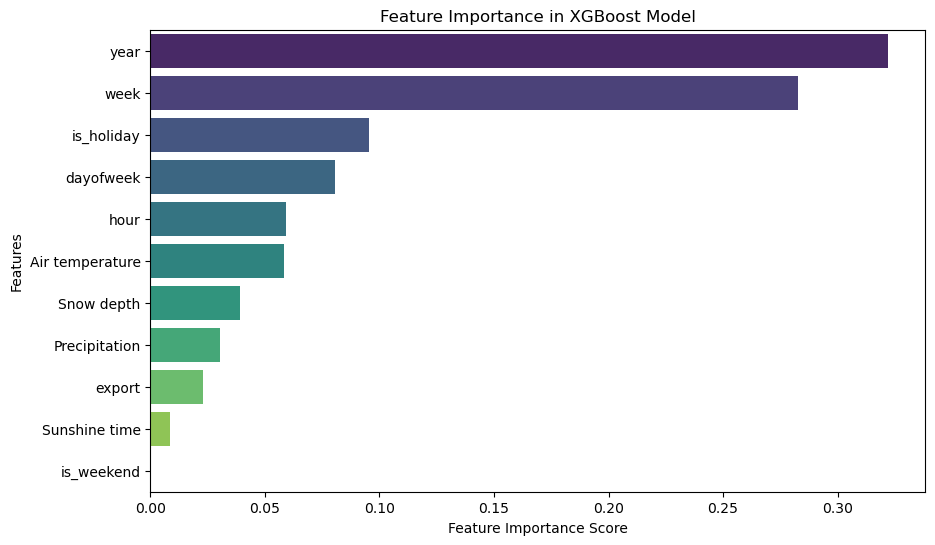

In [14]:
feature_importance = best_xgb.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in XGBoost Model")
plt.show()

# Random Forest Regression

In [9]:

X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(random_state=42)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6, 9, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "auto"],
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search_rf = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid, 
    cv=kf,
    n_jobs=-1,
    verbose=2, 
    scoring="neg_mean_squared_error"
)

grid_search_rf.fit(X_train, y_train)

best_rf = grid_search_rf.best_estimator_

print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

y_pred_rf = best_rf.predict(X_test)

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Mean Absolute Error (MAE): {rf_mae:.4f}")
print(f"Mean Squared Error (MSE): {rf_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rf_rmse:.4f}")
print(f"R-squared (R2): {rf_r2:.4f}")


Fitting 10 folds for each of 144 candidates, totalling 1440 fits


C:\Users\sneha\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
720 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
252 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sneha\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sneha\anaconda3\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\sneha\anaconda3\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\sneha\anaconda3\Lib\site-packa

Best Parameters for Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean Absolute Error (MAE): 8.5459
Mean Squared Error (MSE): 319.5281
Root Mean Squared Error (RMSE): 17.8753
R-squared (R2): 0.9371


# Feature Importance - Random Forest

C:\Users\sneha\AppData\Local\Temp\ipykernel_51784\2958375760.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df_rf['Importance'], y=importance_df_rf['Feature'], palette="viridis")


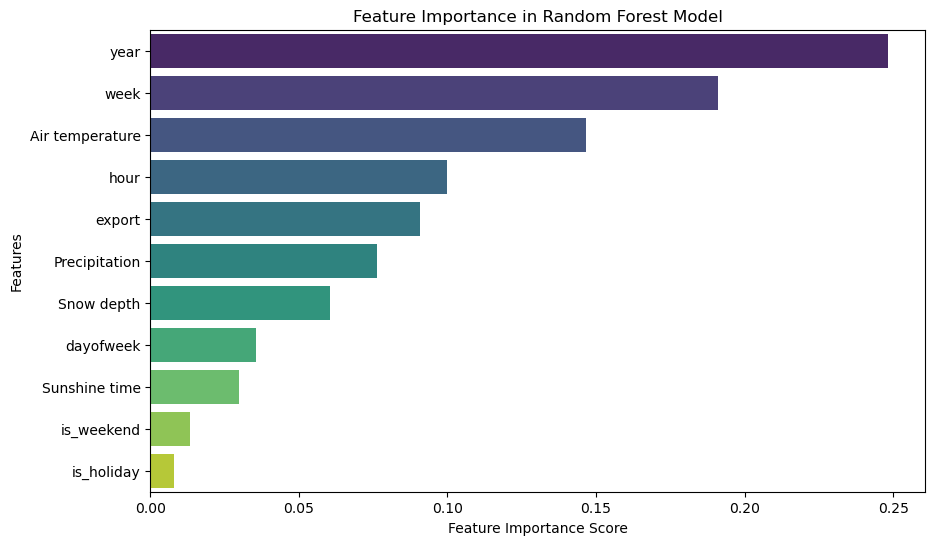

In [15]:
feature_importance_rf = best_rf.feature_importances_
feature_names = X.columns

importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance_rf})
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance_df_rf['Importance'], y=importance_df_rf['Feature'], palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.show()

# Polynomial

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

poly_model = Pipeline([
    ('poly', PolynomialFeatures(interaction_only=True)),  
    ('ridge', Ridge(alpha=10000.0))
])

param_grid = {
    'poly__degree': [2, 3, 4]
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search_poly = GridSearchCV(
    estimator=poly_model, 
    param_grid=param_grid, 
    cv=kf,
    n_jobs=-1, 
    verbose=2, 
    scoring="neg_mean_squared_error"
)

grid_search_poly.fit(X_train, y_train)

best_poly = grid_search_poly.best_estimator_

print("Best Parameters for Polynomial Regression:", grid_search_poly.best_params_)

y_pred_poly = best_poly.predict(X_test)

poly_mae = mean_absolute_error(y_test, y_pred_poly)
poly_mse = mean_squared_error(y_test, y_pred_poly)
poly_rmse = np.sqrt(poly_mse)
poly_r2 = r2_score(y_test, y_pred_poly)

print(f"Mean Absolute Error (MAE): {poly_mae:.4f}")
print(f"Mean Squared Error (MSE): {poly_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {poly_rmse:.4f}")
print(f"R-squared (R2): {poly_r2:.4f}")


Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best Parameters for Polynomial Regression: {'poly__degree': 4}
Mean Absolute Error (MAE): 36.2445
Mean Squared Error (MSE): 3834.6990
Root Mean Squared Error (RMSE): 61.9249
R-squared (R2): 0.2451


# ANN

In [11]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

mse_scores = []
mae_scores = []
r2_scores = []
rmse_scores = []

for train_index, test_index in kf.split(X_scaled_df):
    X_train, X_test = X_scaled_df.iloc[train_index], X_scaled_df.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)  # Output layer
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
    y_pred = model.predict(X_test).ravel()

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)


ann_mse = np.mean(mse_scores)
ann_rmse = np.mean(rmse_scores)
ann_mae = np.mean(mae_scores)
ann_r2 = np.mean(r2_scores)

print(f"Mean Squared Error (MSE): {ann_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {ann_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {ann_mae:.4f}")
print(f"R-squared (R2): {ann_r2:.4f}")


C:\Users\sneha\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


C:\Users\sneha\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


C:\Users\sneha\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


C:\Users\sneha\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


C:\Users\sneha\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


C:\Users\sneha\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


C:\Users\sneha\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


C:\Users\sneha\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\sneha\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


C:\Users\sneha\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 598.3970
Root Mean Squared Error (RMSE): 24.4304
Mean Absolute Error (MAE): 14.4260
R-squared (R2): 0.8869


# Dashboard for all models

In [12]:
results = []

p_results = {
    "Model": "Polynomial",
    "MAE": poly_mae,
    "MSE": poly_mse,
    "RMSE": poly_rmse,
    "R2 Score": poly_r2
}
results.append(p_results)

ann_results = {
    "Model": "ANN",
    "MAE": ann_mae,
    "MSE": ann_mse,
    "RMSE": ann_rmse,
    "R2 Score": ann_r2
}
results.append(ann_results)

rf_results = {
    "Model": "Random Forest",
    "MAE": rf_mae,
    "MSE": rf_mse,
    "RMSE": rf_rmse,
    "R2 Score": rf_r2
}
results.append(rf_results)

xgb_results = {
    "Model": "XGBoost",
    "MAE": xgb_mae,
    "MSE": xgb_mse,
    "RMSE": xgb_rmse,
    "R2 Score": xgb_r2
}
results.append(xgb_results)

comparison_df = pd.DataFrame(results)

display(comparison_df)


,Model,MAE,MSE,RMSE,R2 Score
0,Polynomial,36.244464,3834.699015,61.924947,0.245056
1,ANN,14.426013,598.397016,24.430360,0.886924
2,Random Forest,8.545941,319.528055,17.875348,0.937094
3,XGBoost,9.141240,293.996739,17.146333,0.942120


# R2 Comparison for all models

C:\Users\sneha\AppData\Local\Temp\ipykernel_51784\1726069534.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2 Score', data=comparison_df, palette='viridis')


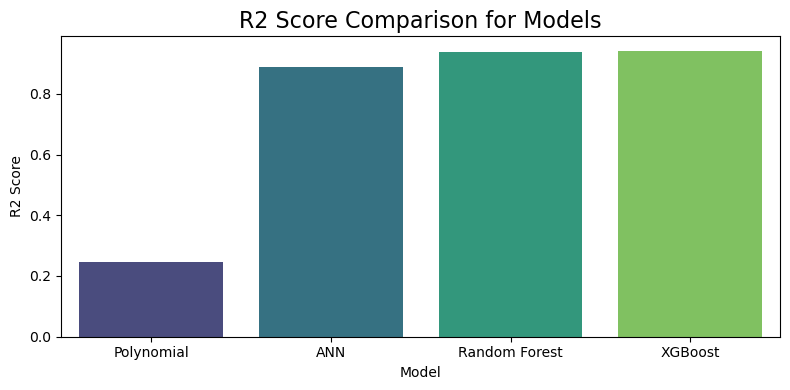

In [13]:

plt.figure(figsize=(8, 4))
sns.barplot(x='Model', y='R2 Score', data=comparison_df, palette='viridis')


plt.title('R2 Score Comparison for Models', fontsize=16)
plt.xlabel('Model', fontsize=10)
plt.ylabel('R2 Score', fontsize=10)


plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
